In [31]:
#1차 데이터 전처리 특성중요도 0.01미만 54개 제거
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# 데이터 불러오기
data = pd.read_csv('./train_data.csv')

# 특성과 타겟 변수 분리
data_input = data.drop(columns=['Bankrupt?'])
data_target = data['Bankrupt?']

# 데이터 분리
train_input, test_input, train_target, test_target = train_test_split(
    data_input, data_target, random_state=42)

# 랜덤 포레스트 모델 학습
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(train_input, train_target)

# 특성 중요도 확인
importances = rf_model.feature_importances_
features = data_input.columns
feature_importances = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# 중요도가 낮은 특성 제거 (중요도 0.01 미만인 특성 제거)
important_features = feature_importances[feature_importances['Importance'] > 0.01]['Feature']
data_input_reduced = data_input[important_features]

# 중요한 특성만 포함한 데이터프레임에 타겟 변수 'Bankrupt?' 컬럼 추가
data_reduced_with_target = data_input_reduced.copy()
data_reduced_with_target['Bankrupt?'] = data_target


data_reduced_with_target.to_csv('./train_data_reduced.csv', index=False)



In [32]:
# 제거할 특성 불러오기
low_importance_features = pd.read_csv('./low_importance_features.csv')['Feature'].tolist()

# 새로운 데이터 불러오기
test_data = pd.read_csv('./test_data.csv')

# 제거할 특성을 데이터에서 제거
test_data_reduced = test_data.drop(columns=low_importance_features)

# 중요한 특성만 포함된 새로운 데이터 저장
file_path_test_reduced = './test_data_reduced.csv'
test_data_reduced.to_csv(file_path_test_reduced, index=False)

file_path_test_reduced

'./test_data_reduced.csv'

In [33]:
test_data = pd.read_csv('./test_data_reduced.csv')
ntest_input = test_data.drop(columns=['Bankrupt?'])
ntest_input_reduced = ntest_input[important_features]
ntest_target = test_data['Bankrupt?']

In [29]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import matplotlib.pyplot as plt

data = pd.read_csv('./train_data_reduced.csv')

# 데이터 분리 (중요도가 낮은 특성 제거 후)
train_input_reduced, test_input_reduced, train_target_reduced, test_target_reduced = train_test_split(
    data_input_reduced, data_target, random_state=42)

# 랜덤 포레스트 모델 재학습
rf_model_reduced = RandomForestClassifier(random_state=42)
rf_model_reduced.fit(train_input_reduced, train_target_reduced)


# 3. 하이퍼파라미터 튜닝
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, 15],
    'min_samples_split': [10, 15],
    'min_samples_leaf': [4, 6],
    'bootstrap': [True]
}

grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                           param_grid=param_grid,
                           cv=5,
                           n_jobs=-1,
                           scoring='accuracy')
grid_search.fit(train_input_reduced, train_target_reduced)

best_rf_model = grid_search.best_estimator_

print("최적의 하이퍼파라미터:", grid_search.best_params_)

# 최적의 하이퍼파라미터로 모델 재학습
best_rf_model.fit(train_input_reduced, train_target_reduced)

# 예측 (하이퍼파라미터 튜닝 후)
train_predictions_tuned = best_rf_model.predict(train_input_reduced)
test_predictions_tuned = best_rf_model.predict(test_input_reduced)
ntest_predictions_tuned = best_rf_model.predict(ntest_input_reduced)

# 모델 평가 - 정확도 (하이퍼파라미터 튜닝 후)
train_accuracy_tuned = accuracy_score(train_target_reduced, train_predictions_tuned)
test_accuracy_tuned = accuracy_score(test_target_reduced, test_predictions_tuned)
ntest_accuracy_tuned = accuracy_score(ntest_target, ntest_predictions_tuned)

print(f"훈련 세트 정확도 (하이퍼파라미터 튜닝 후): {train_accuracy_tuned}")
print(f"테스트 세트 정확도 (하이퍼파라미터 튜닝 후): {test_accuracy_tuned}")
print(f"ntest 세트 정확도 (하이퍼파라미터 튜닝 후): {ntest_accuracy_tuned}")

# 교차 검증 (Cross-Validation, 하이퍼파라미터 튜닝 후)
cv_scores_tuned = cross_val_score(best_rf_model, data_input_reduced, data_target, cv=5)
cv_accuracy_tuned = np.mean(cv_scores_tuned)

# 교차 검증 평가 - MSE, MAE (하이퍼파라미터 튜닝 후)
cv_predictions_tuned = cross_val_predict(best_rf_model, data_input_reduced, data_target, cv=5)

print("교차 검증 평균 정확도 (하이퍼파라미터 튜닝 후): ", cv_accuracy_tuned)


최적의 하이퍼파라미터: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 6, 'min_samples_split': 10, 'n_estimators': 100}
특성 제거 후 모델 성능:
훈련 세트 정확도 (하이퍼파라미터 튜닝 후): 0.9777560498655585
테스트 세트 정확도 (하이퍼파라미터 튜닝 후): 0.9714076246334311
ntest 세트 정확도 (하이퍼파라미터 튜닝 후): 0.9860703812316716
교차 검증 평균 정확도 (하이퍼파라미터 튜닝 후):  0.965352887259395


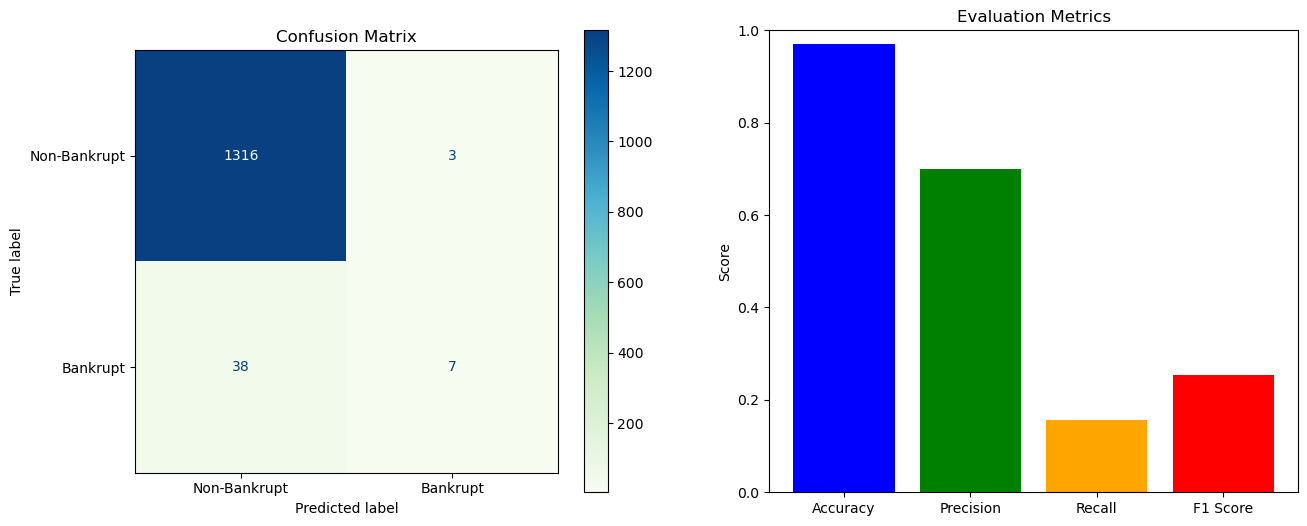

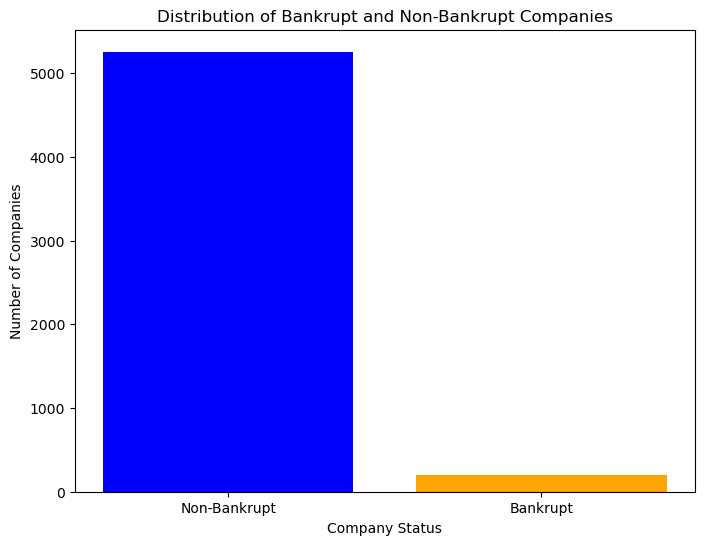

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

# 데이터 불러오기
data = pd.read_csv('./train_data.csv')

# 특성과 타겟 변수 분리
data_input = data.drop(columns=['Bankrupt?'])
data_target = data['Bankrupt?']

# 데이터 분리
train_input, test_input, train_target, test_target = train_test_split(
    data_input, data_target, random_state=42)

# 랜덤 포레스트 모델 학습 및 예측
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(train_input, train_target)
test_predictions = rf_model.predict(test_input)

# 평가 지표 계산
accuracy = accuracy_score(test_target, test_predictions)
precision = precision_score(test_target, test_predictions)
recall = recall_score(test_target, test_predictions)
f1 = f1_score(test_target, test_predictions)

# 혼동 행렬 생성
conf_matrix = confusion_matrix(test_target, test_predictions)

# 시각화
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# 혼동 행렬 시각화
ConfusionMatrixDisplay(conf_matrix, display_labels=['Non-Bankrupt', 'Bankrupt']).plot(ax=axes[0], cmap = 'GnBu')
axes[0].set_title('Confusion Matrix')

# 평가 지표 시각화
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
scores = [accuracy, precision, recall, f1]
axes[1].bar(metrics, scores, color=['blue', 'green', 'orange', 'red'])
axes[1].set_ylim(0, 1)
axes[1].set_title('Evaluation Metrics')
axes[1].set_ylabel('Score')

plt.show()

# 타겟 변수 분포 확인
target_counts = data_target.value_counts()

# 불균형 데이터 시각화
plt.figure(figsize=(8, 6))
plt.bar(target_counts.index, target_counts.values, color=['blue', 'orange'])
plt.xticks(target_counts.index, ['Non-Bankrupt', 'Bankrupt'])
plt.xlabel('Company Status')
plt.ylabel('Number of Companies')
plt.title('Distribution of Bankrupt and Non-Bankrupt Companies')
plt.show()


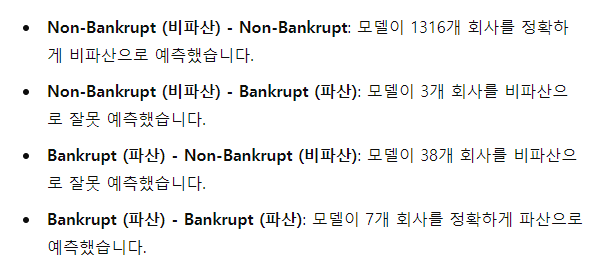

- Accuracy (정확도): 전체 예측 중에서 올바르게 예측한 비율입니다. 이 경우 약 97%로 매우 높습니다.
- Precision (정밀도): 모델이 파산으로 예측한 회사 중 실제로 파산인 회사의 비율입니다. 약 0.7로 비교적 낮습니다.
- Recall (재현율): 실제 파산인 회사 중 모델이 정확히 파산으로 예측한 비율입니다. 약 0.16으로 매우 낮습니다.
- F1 Score: 정밀도와 재현율의 조화 평균입니다. 약 0.26으로 낮습니다.
- 정확도는 매우 높지만, 데이터 불균형 문제로 인해 정밀도, 재현율, F1 점수가 낮습니다. 이는 모델이 비파산 회사를 예측하는 데 매우 강하지만, 파산 회사를 잘 예측하지 못한다는 것을 의미합니다.

- 혼동 행렬은 모델이 비파산 회사를 잘 예측하지만, 파산 회사를 잘 예측하지 못한다는 것을 보여줍니다.
- 평가 지표는 높은 정확도에도 불구하고, 정밀도, 재현율, F1 점수가 낮아 모델의 예측 성능이 파산 예측에 약하다는 것을 시사합니다.
- 데이터 분포는 데이터셋이 매우 불균형하다는 것을 시각적으로 보여줍니다.
- 결론적으로, 높은 정확도는 데이터 불균형 문제를 반영하지 못하며, 모델의 성능을 평가하는 데 있어 정밀도, 재현율, F1 점수와 같은 다른 평가 지표를 고려해야 합니다. 이를 통해 모델이 실제로 중요한 파산 예측에서 얼마나 잘 수행되는지를 평가할 수 있습니다.